## ML Random Forest Classifier for predicting Next Lever Press from Previous Outcome AUC

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
!pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree




[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data = pd.read_csv('E:/WPPhotometer/RZ10X/High/HighWSLS_40ex.csv')



In [3]:
removeBlocks = data[data['Trial#'] > 40]
removeLastTrial = removeBlocks[~removeBlocks['NextLever'].isin(['End'])]
filteredData = removeLastTrial

filteredData['NextLever'] = filteredData['NextLever'].map({'Small': 0, 'Omission': 0, 'Punished': 1, 'UnPunished':1})
filteredData['Lever'] = filteredData['Lever'].map({'Small': 0, 'Punished': 1, 'UnPunished':1})

# Step 2: Display the first few rows of the DataFrame to ensure it loaded correctly
print(filteredData.head())

    ID    Date  Trial#  Lever  NextLever      WSLS  LeverZmax  LeverZmin  \
40  16  230123      41      1          1   WinStay   1.032254  -2.801675   
41  16  230123      42      1          1   WinStay   1.322393  -1.459220   
42  16  230123      43      1          1  LoseStay   0.089852 -13.977067   
43  16  230123      44      1          1  LoseStay   3.632940  -4.789615   
44  16  230123      45      1          1  LoseStay   2.964364  -3.106914   

      LeverAUC    HLZmax    HLZmin       HLauc  
40  -58.215458  2.377784 -0.235866  134.330191  
41   -0.330189  1.020918 -2.936542  -73.036075  
42 -340.391502  3.388886 -1.420842   66.112603  
43  -83.760736  2.193811 -1.229327   19.508683  
44 -152.761583 -0.081433 -2.495348 -117.517412  


C:\Users\wonnp\AppData\Local\Temp\ipykernel_33324\3672174298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredData['NextLever'] = filteredData['NextLever'].map({'Small': 0, 'Omission': 0, 'Punished': 1, 'UnPunished':1})
C:\Users\wonnp\AppData\Local\Temp\ipykernel_33324\3672174298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredData['Lever'] = filteredData['Lever'].map({'Small': 0, 'Punished': 1, 'UnPunished':1})


In [4]:
# Step 3: Extract the features and target
X = filteredData[['ID', 'LeverAUC']]  # Replace 'Group ID' and 'Predictor' with your actual column names
y = filteredData['NextLever']  # Replace 'Response' with your actual response column name


In [5]:
# Step 4: Standardize the continuous predictor variable
scaler = StandardScaler()
X.loc[:,'LeverAUC'] = scaler.fit_transform(X[['LeverAUC']])

In [6]:
# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=X['ID'], random_state=42)


In [7]:
# Step 7: Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [8]:
# Step 8: Train the model on the training set
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
# Step 9: Evaluate the model on the testing set
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)

print(f'Test AUC: {auc}')

Test AUC: 0.8218899963086009


In [10]:
# Optional: Cross-validation on the training set
group_kfold = GroupKFold(n_splits=5)
# Custom cross-validation loop to handle single-class splits
auc_scores = []
for train_index, test_index in group_kfold.split(X_train, y_train, groups=X_train['ID']):
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ensure both classes are present in the test set
    if len(np.unique(y_cv_test)) > 1:
        rf_model.fit(X_cv_train, y_cv_train)
        y_cv_pred_prob = rf_model.predict_proba(X_cv_test)[:, 1]
        auc_score = roc_auc_score(y_cv_test, y_cv_pred_prob)
        auc_scores.append(auc_score)
    else:
        print("Only one class present in y_true for this fold, skipping AUC calculation for this fold.")

print(f'Cross-validated AUC scores: {auc_scores}')
print(f'Mean AUC: {np.mean(auc_scores) if auc_scores else float("nan")}')

Only one class present in y_true for this fold, skipping AUC calculation for this fold.
Cross-validated AUC scores: [np.float64(0.7572463768115942), np.float64(0.19444444444444442), np.float64(0.7048148148148149), np.float64(0.48878048780487804)]
Mean AUC: 0.5363215309689329


In [11]:
# Step 10: View feature importance
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

print("Feature Importances:")
for name, importance in zip(feature_names, feature_importances):
    print(f'{name}: {importance:.4f}')

Feature Importances:
ID: 0.5604
LeverAUC: 0.4396


In [12]:
print("Random Forest Hyperparameters:")
print(rf_model.get_params())


Random Forest Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


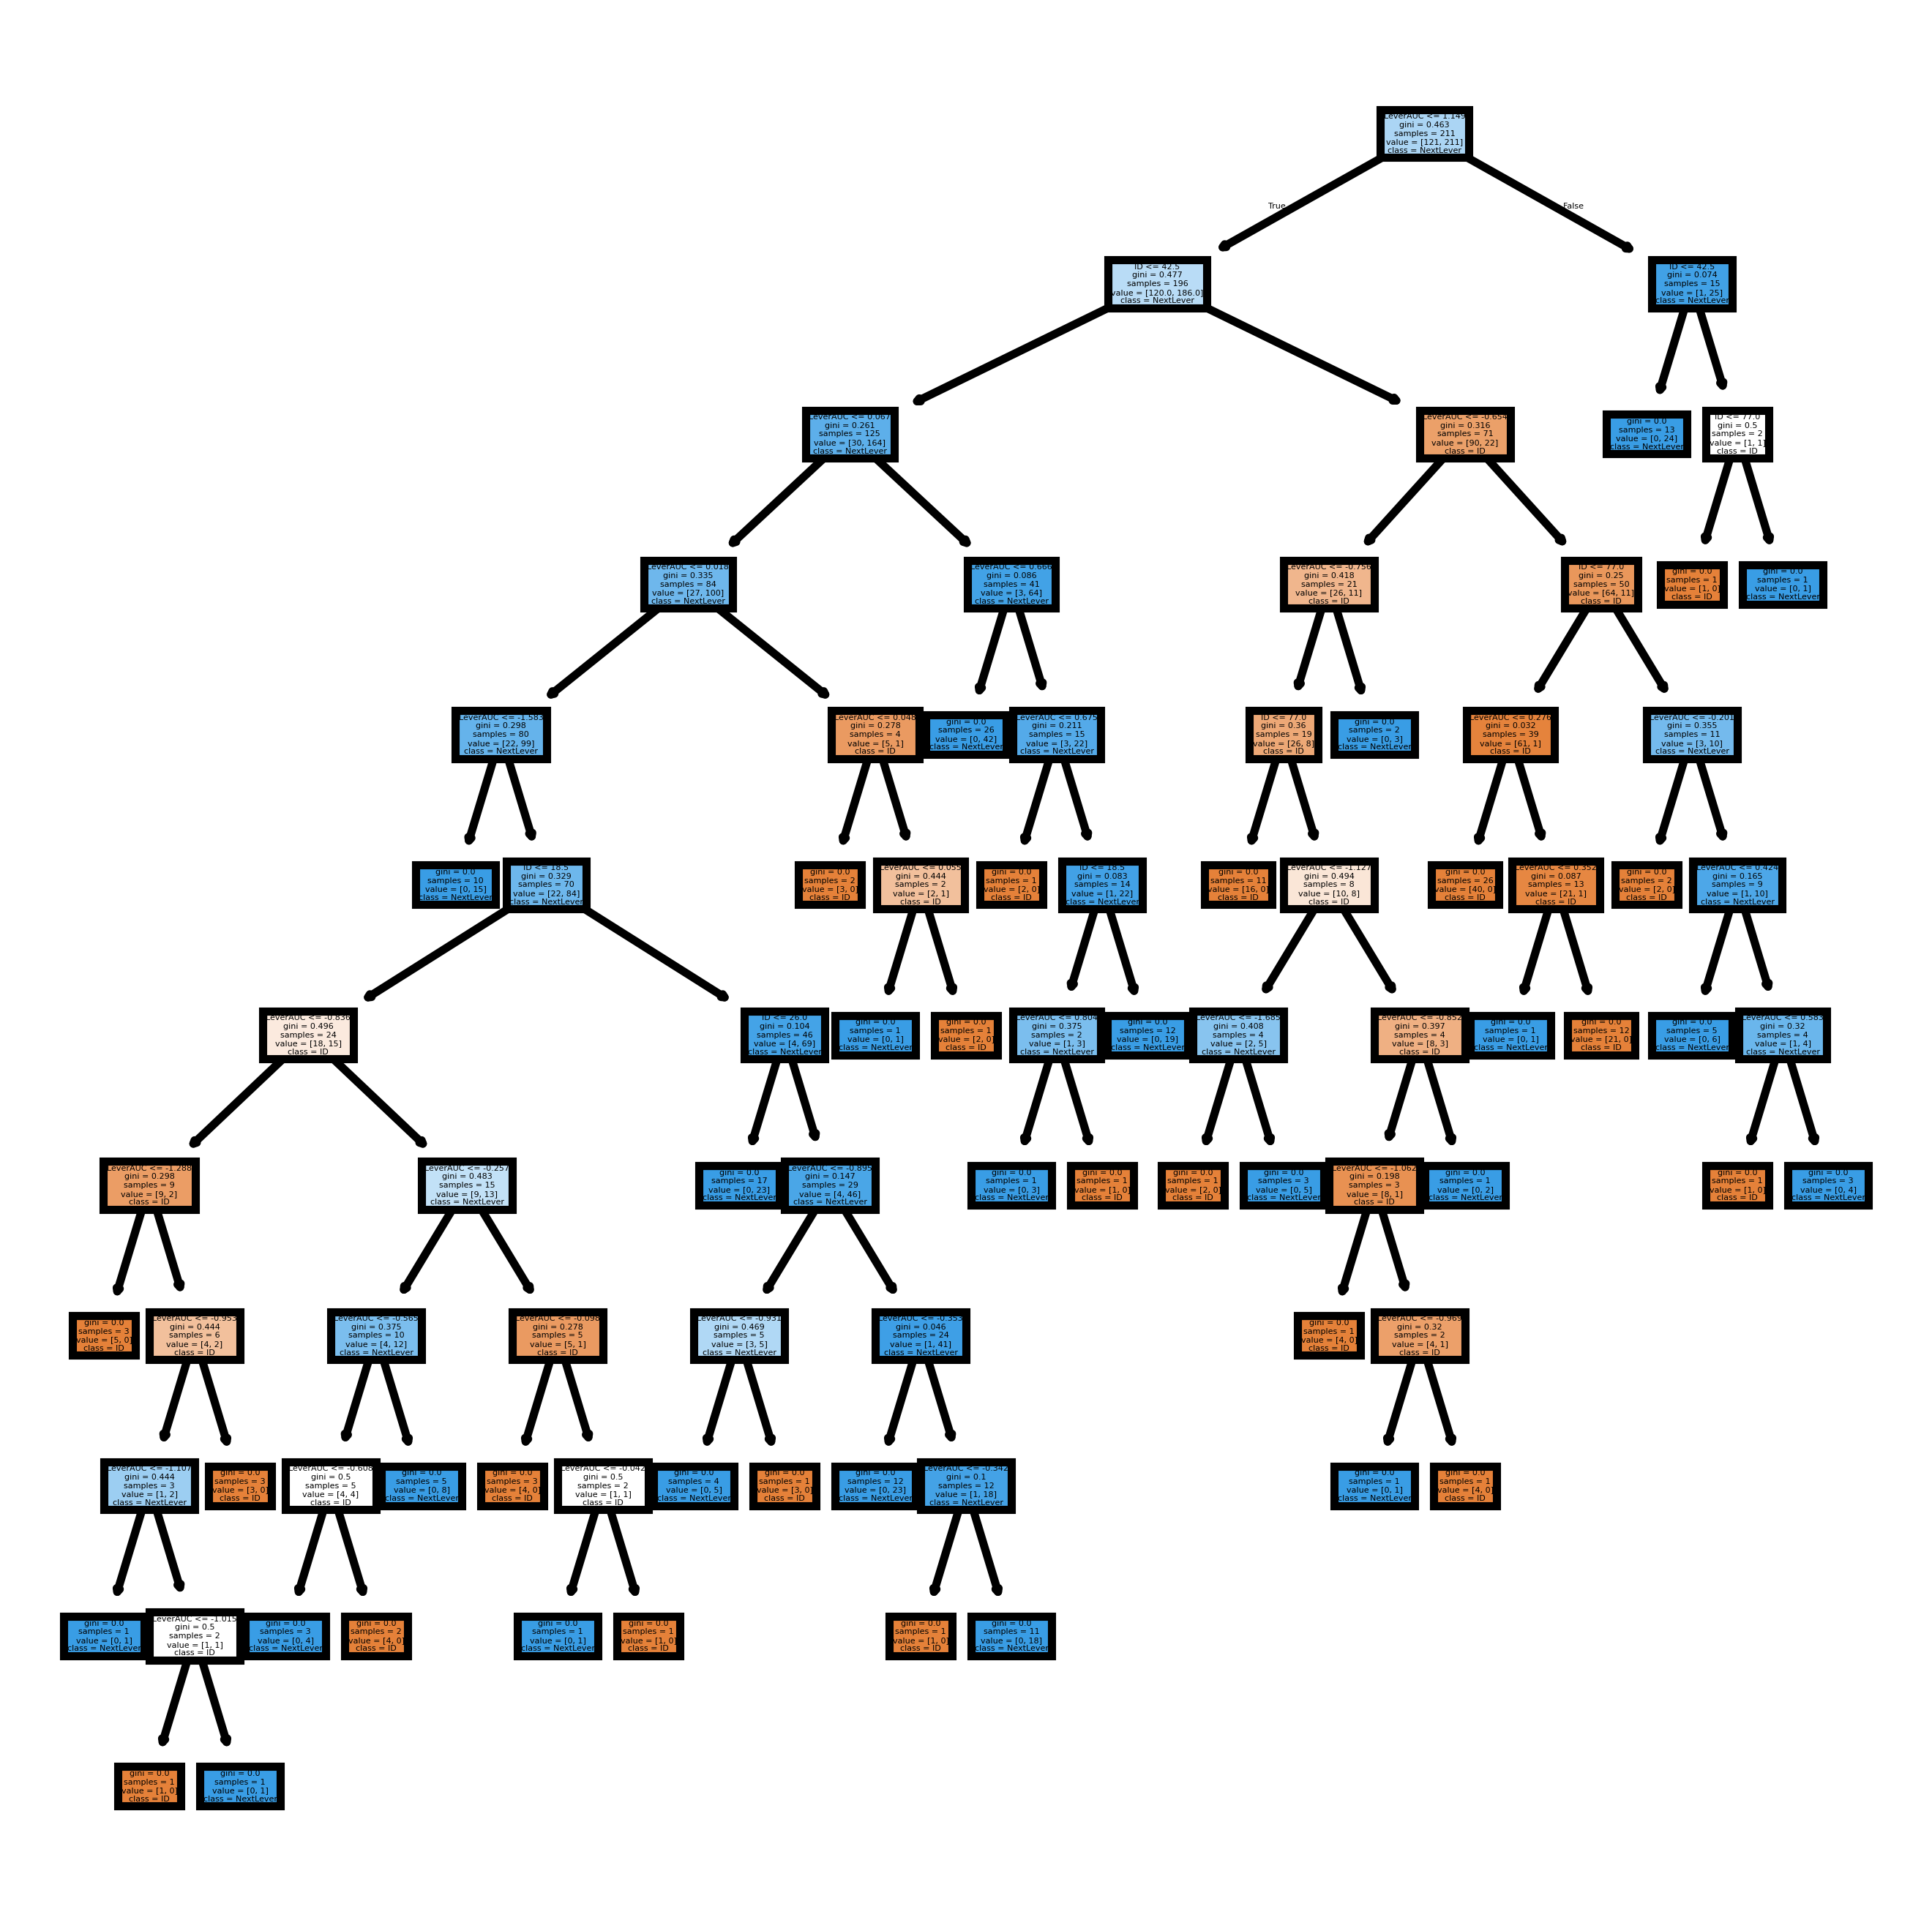

In [18]:
df = filteredData[['ID', 'NextLever']]

fn=X_train.columns
cn=df.columns

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
#fig.savefig('rf_individualtree.png')

In [14]:
# # Step 1: Load the New Data
# # Replace this with the actual path to your new data file
# new_data_path = 'E:/WPPhotometer/RZ10X/High/testData.csv'
# new_data = pd.read_csv(new_data_path)

# removeBlocks = new_data[new_data['Trial#'] > 40]
# removeLastTrial = removeBlocks[~removeBlocks['NextLever'].isin(['End'])]
# filteredData = removeLastTrial

# filteredData['NextLever'] = filteredData['NextLever'].map({'Small': 0, 'Omission': 0, 'Punished': 1, 'UnPunished':1})
# filteredData['Lever'] = filteredData['Lever'].map({'Small': 0, 'Punished': 1, 'UnPunished':1})

# # Step 2: Display the first few rows of the DataFrame to ensure it loaded correctly
# print(filteredData.head())

In [15]:
# # Step 2: Preprocess the New Data
# # Assuming new_data has the same columns as the original training data,
# # and 'LeverAUC' and 'Predictor2' are the continuous predictors to be standardized

# # Standardize the continuous predictors
# filteredData[['LeverAUC']] = scaler.transform(filteredData[['LeverAUC']])


In [16]:
# # Step 3: Use the Trained Model to Make Predictions
# # Assuming 'Group ID' is also present in new_data
# X_new = filteredData[['ID', 'Lever', 'LeverAUC']]

# # Make predictions (probabilities) with the trained model
# predicted_probabilities = rf_model.predict_proba(X_new)[:, 1]

# # Make predictions (class labels) with the trained model
# predicted_classes = rf_model.predict(X_new)

# # Display the predictions
# print("Predicted Probabilities:")
# print(predicted_probabilities)

# print("Predicted Classes:")
# print(predicted_classes)